This notebook provides an example of how to fit a simple reinforcement learning model to a dataset. For an excellent guide to how to fit models to data, please have a look at http://www.princeton.edu/~ndaw/d10.pdf

In [78]:
# set up imports
import numpy
import statsmodels.nonparametric.smoothers_lowess
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline

First, we need to generate some data.

In [149]:
# softmax response function
def softmax(q,temp):
        p=numpy.exp(q[0]/temp)/(numpy.exp(q[0]/temp)+numpy.exp(q[1]/temp))
        if p>numpy.random.rand():
            return 0
        else:
            return 1
        
# function to generate probabilistic outcomes
# p_A is probability of reward for outcome 1
def outcome(resp,p_A=0.75):
    if numpy.random.rand()<p_A:
        rewarded_outcome=1
    else:
        rewarded_outcome=0
    if resp==rewarded_outcome:
        return 1
    else:
        return 0
    
correct_resp=numpy.zeros(1000)
correct_resp[100:200]=1
correct_resp[300:400]=1
correct_resp[500:550]=1
correct_resp[600:650]=1
correct_resp[700:800]=1
correct_resp[900:1000]=1




In [150]:
# forward model to generate data using q-learning
def generate_data(learning_rate=0.01,temp=0.05,p_A=0.75):

    ntrials=correct_resp.shape[0]
    q=[0.0,0,0]

    resp=numpy.zeros(ntrials)
    reward=numpy.zeros(ntrials)
    correct=numpy.zeros(ntrials)


    for i in range(ntrials):
        resp[i]=softmax(q,temp)
        reward[i]=outcome(resp[i],p_A)
        correct[i]=resp[i]==correct_resp[i]
        q[int(resp[i])]=q[int(resp[i])] + learning_rate*(reward[i]-q[int(resp[i])])

    return resp,reward,correct,learning_rate,temp

In [151]:

def block_summary(resp,blocksize=20):
    ntrials=resp.shape[0]
    blocksize=20
    nblocks=int(ntrials/blocksize)
    block_reward=numpy.zeros(nblocks)
    for i in range(nblocks):
        block_trials=numpy.arange(i*blocksize,(i+1)*blocksize)
        block_reward[i]=numpy.mean(resp[block_trials]==1)
    return block_reward,blocksize



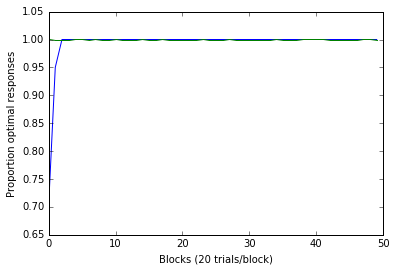

In [152]:
resp,reward,correct,learning_rate,temp=generate_data()

block_reward,blocksize=block_summary(resp)
plt.plot(block_reward)
smooth=statsmodels.nonparametric.smoothers_lowess.lowess(block_reward,numpy.arange(block_reward.shape[0]),frac=0.33)
plt.plot(smooth[:,1])
plt.xlabel('Blocks (%d trials/block)'%blocksize)
plt.ylabel('Proportion optimal responses')

In [123]:
print('mean proportion rewarded trials: %0.3f'%numpy.mean(reward))

mean proportion rewarded trials: 0.690


Now, we want to fit a model to the behavior above.  It is challenging to estimate both the learning rate and temperature parameters, so we will just fix temperature and estimate learning rate.  We first need to implement the likelihood function for the Q-learning model.

In [144]:
def q_negloglike(params):
    lr=params[0]
    temp_t=1
    
    assert resp.shape[0]==reward.shape[0]
    
    q=[0.0,0,0]
    ll_sum=0
    
    for i in range(resp.shape[0]):
        # log of choice probability (from Daw): β · Qt(ct) − log(exp(β · Qt(L)) + exp(β · Qt(R)))
        ll_sum+=temp_t*q[int(resp[i])] - numpy.log(numpy.exp(q[0]*temp_t)+numpy.exp(q[1]*temp_t))
        q[int(resp[i])]=q[int(resp[i])] + lr*(reward[i]-q[int(resp[i])])
    # return negative LL for minimizing
    return -1*ll_sum
        

Fit the likelihood function to the data by maximum likelihood

In [145]:
def ml_est(start=None):
    if not start:
        start=[numpy.random.rand()*0.1]
    result=minimize(q_negloglike,start)
    if result['success']:
        return result['x']
    else:
        return [numpy.nan]

Let's generate a bunch of datasets and look at how well the model fits.  for each model, compute estimates using multiple starting points (randomly chosen within the allowable range of parameter values)

In [146]:
nruns=100
nests=10
negll=numpy.zeros(nruns)
nanctr=0

for r in range(nruns):
    est=numpy.zeros(nests)
    for e in range(nests):
        resp,reward,correct,learning_rate,temp=generate_data()
        mle=ml_est()
        if numpy.isnan(mle[0]):
            nanctr+=1
        est[e]=mle[0]
    negll[r]=numpy.nanmean(est)
    print(numpy.hstack((r,negll[r])))

   

[ 0.          0.81155439]


KeyboardInterrupt: 

In [148]:
result=minimize(q_negloglike,0.5)
print(result)

  message: 'Desired error not necessarily achieved due to precision loss.'
   status: 2
      jac: array([ nan])
        x: array([ 19050.41015625])
     nfev: 126
 hess_inv: array([[1]])
     njev: 42
      nit: 1
      fun: nan
  success: False


In [ ]:

plt.subplot(1,2,1)
plt.hist(negll[:,0].ravel())
plt.title('learning rate (true=%0.4f)'%learning_rate)
plt.subplot(1,2,2)
plt.hist(negll[:,1].ravel())
plt.title('temperature (true=%0.4f)'%temp)

Now let's compute the likelihood function across a grid of values, so that we can visualize the likelihood surface.

In [54]:
lr_range=numpy.linspace(0,0.2,100)
temp_range=numpy.linspace(0,1,100)
negLL=numpy.zeros((len(lr_range),len(temp_range)))
for lr in range(len(lr_range)):
    for t in range(len(temp_range)):
        negLL[lr,t]=q_negloglike([lr_range[lr],temp_range[t]])

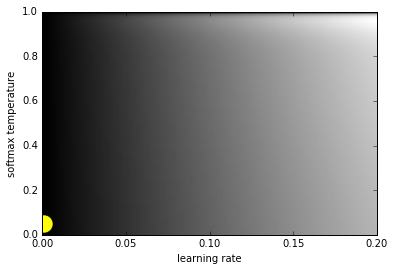

In [55]:
plt.imshow(-1*negLL,aspect='auto',cmap='gray',
           extent=[numpy.min(lr_range),numpy.max(lr_range),numpy.min(temp_range),numpy.max(temp_range)])
plt.xlabel('learning rate')
plt.ylabel('softmax temperature')
plt.plot(learning_rate,temp,marker='o',markersize=18,color='yellow')
#plt.plot(loglike[80,:10])

In [50]:
numpy.where(loglike==numpy.max(loglike))

(array([7]), array([99]))

In [51]:
loglike

array([[-693.14718056, -693.14718056, -693.14718056, ..., -693.14718056,
        -693.14718056, -693.14718056],
       [-693.14718056, -692.11371928, -691.08186904, ..., -600.36775513,
        -599.48911822, -598.61204777],
       [-693.14718056, -691.56825702, -689.99294912, ..., -556.66990743,
        -555.43521753, -554.20394516],
       ..., 
       [-693.14718056, -691.49976054, -689.85660564, ..., -553.02853588,
        -551.78746723, -550.55043857],
       [-693.14718056, -691.50141675, -689.85991654, ..., -553.18184906,
        -551.94227813, -550.70674534],
       [-693.14718056, -691.50307607, -689.86323366, ..., -553.33541767,
        -552.09734664, -550.86331187]])